In [1]:
import numpy as np

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(
    style="whitegrid", font_scale=1.2, context="talk",
    palette=sns.color_palette("bright"), color_codes=False)
# consider using TrueType fonts if submitting to a conference
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (8, 6)

PLOT_PATH = '../plots/'
MARKERS = ['o', 'v', 's', 'P', 'p', '*', 'H', 'X', 'D']

In [2]:
n = 6
n_s = np.array([1, 2, 3])
n_clients = len(n_s)

In [3]:
class QuadObjAlg(object):
    def __init__(self, n, n_s, algo, eta, sample=False, sum_one=False, mom=0.0, full_epoch=True): 
        assert n == sum(n_s)
        self.algo = algo
        self.n_clients = len(n_s)
        self.n_s = n_s
        self.w_s = np.ones(self.n_clients) / self.n_clients if algo == 'FedNova' else self.n_s / n
        self.w_s_data = self.n_s / n
        cs = np.concatenate([[0], np.cumsum(n_s)])
        self.local_ind = [np.arange(cs[i], cs[i+1]) for i in range(self.n_clients)]
        self.data = np.diag(np.ones(n))
        self.x_opt = self.data.mean(axis=0)
        self.x = np.zeros(n)
        self.x_old = np.zeros(n)
        self.local_updates = np.zeros((self.n_clients, n))
        self.eta = eta
        self.sample = sample
        self.sum_one = sum_one
        self.mom = mom
        self.mom_grad = np.zeros(n)
        self.local_gradients = None if mom == 0. else np.zeros((self.n_clients, n))
        self.local_gradients_old = None if mom == 0. else np.zeros((self.n_clients, n))
        self.full_epoch = full_epoch

    def local_round(self, client_id_s, prob_s):
        for client_id in client_id_s:
            self.local_updates[client_id] = self.local_epoch(client_id)
            if self.mom > 0.:
                ind_s = self.local_ind[client_id]
                self.local_gradients[client_id] = self.x - self.data[ind_s].mean(axis=0)
                self.local_gradients_old[client_id] = self.x_old - self.data[ind_s].mean(axis=0)
        dist = self.agg(prob_s, client_id_s)
        return dist
    
    def local_epoch(self, client_id):
        n_s = self.n_s
        n = self.n_s[client_id]
        ind_s = self.local_ind[client_id]
        eta = self.eta / n if self.algo == 'FedShuffle' else self.eta / np.max(n_s)
        x_l = np.copy(self.x)
        shuffle_ind = np.arange(n)
        np.random.shuffle(shuffle_ind)

        for j in range(n):
            ind = np.random.choice(n) if self.sample else shuffle_ind[j]
            i = ind_s[ind]
            x_l = self.local_step(x_l, i, eta)
            if not self.full_epoch:
                break
        
        return x_l - self.x
        
    
    def local_step(self, x, i, eta):
        grad = x - self.data[i]
        if self.mom > 0:
            old_grad = self.x - self.data[i]
            v = grad + self.mom * (self.mom_grad - old_grad)
            return x - eta * v
        else: 
            return x - eta * grad
    
    def dist(self):
        return np.sum((self.x - self.x_opt)**2)
    
    def agg(self, prob_s, client_id_s):
        w_s = self.w_s / prob_s
        w_s_data = self.w_s_data / prob_s
        if self.sum_one:
            w_s[client_id_s] /= np.sum(w_s[client_id_s])
            w_s_data[client_id_s] /= np.sum(w_s_data[client_id_s])
        update = (self.local_updates * w_s.reshape(-1, 1)).sum(axis=0)
        self.x_old = self.x
        self.x = self.x + update
        self.local_updates = np.zeros((self.n_clients, n))
        if self.mom > 0:
            grad_update = (self.local_gradients * w_s_data.reshape(-1, 1)).sum(axis=0)
            grad_old_update = (self.local_gradients_old * w_s_data.reshape(-1, 1)).sum(axis=0)
            self.mom_grad = grad_update + self.mom * (self.mom_grad - grad_old_update)
            self.local_gradients = np.zeros((self.n_clients, n))
            self.local_gradients_old = np.zeros((self.n_clients, n))
        return self.dist()

In [4]:
comm_rounds = 1000
eta = 1/80

## Full Participation: All Algorithms

In [5]:
prob_s = np.ones(n_clients)
random_seed_s = [123, 124, 125]
run_stat_s = [np.zeros((6, comm_rounds)) for _ in random_seed_s]


for i, random_seed in enumerate(random_seed_s):
    fedavg = QuadObjAlg(n, n_s, 'FedAvg', eta, True)
    fedavg_rr = QuadObjAlg(n, n_s, 'FedAvg', eta, False)
    fedavg_min = QuadObjAlg(n, n_s, 'FedAvg', 3 * eta, False, full_epoch=False)
    fednova = QuadObjAlg(n, n_s, 'FedNova', eta, True)
    fednova_rr = QuadObjAlg(n, n_s, 'FedNova', eta, False)
    fedshuffle = QuadObjAlg(n, n_s, 'FedShuffle', eta, False)
    np.random.seed(random_seed)

    for c in range(comm_rounds):
        round_ids = np.arange(n_clients)
        run_stat_s[i][0, c] = fedavg.local_round(round_ids, prob_s)
        run_stat_s[i][1, c] = fedavg_rr.local_round(round_ids, prob_s)
        run_stat_s[i][2, c] = fedavg_min.local_round(round_ids, prob_s)
        run_stat_s[i][3, c] = fednova.local_round(round_ids, prob_s)
        run_stat_s[i][4, c] = fednova_rr.local_round(round_ids, prob_s)
        run_stat_s[i][5, c] = fedshuffle.local_round(round_ids, prob_s)

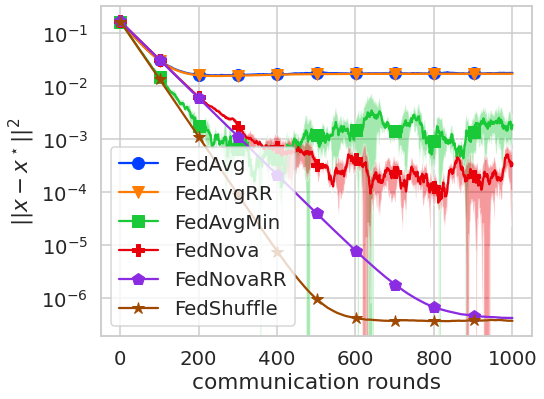

In [6]:
fig, ax = plt.subplots()

for i in range(6):
    x = np.arange(1, comm_rounds + 1)
    quant = [run_stat_s[j][i] for j in range(len(random_seed_s))]
    mean = np.nanmean(quant, axis=0)
    std = np.nanstd(quant, axis=0)
    ax.plot(x, mean, marker=MARKERS[i], markersize=12, markevery=len(x) // 10)
    ax.fill_between(x, mean + std, mean - std, alpha=0.4)
ax.legend(['FedAvg', 'FedAvgRR' , 'FedAvgMin', 'FedNova', 'FedNovaRR', 'FedShuffle'])
ax.set_yscale('log')
ax.set_xlabel('communication rounds')
ax.set_ylabel(r"$||x - x^\star||^2$")
plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/toy_all.pdf")
plt.show()

In [12]:
prob_s = np.ones(n_clients)
random_seed_s = [123, 124, 125]
run_stat_s = [np.zeros((6, comm_rounds)) for _ in random_seed_s]


for i, random_seed in enumerate(random_seed_s):
    fedavg = QuadObjAlg(n, n_s, 'FedAvg', eta, True, mom=0.9)
    fedavg_rr = QuadObjAlg(n, n_s, 'FedAvg', eta, False, mom=0.9)
    fedavg_min = QuadObjAlg(n, n_s, 'FedAvg', 3 * eta, False, mom=0.9, full_epoch=False)
    fednova = QuadObjAlg(n, n_s, 'FedNova', eta, True, mom=0.9)
    fednova_rr = QuadObjAlg(n, n_s, 'FedNova', eta, False, mom=0.9)
    fedshuffle = QuadObjAlg(n, n_s, 'FedShuffle', eta, False, mom=0.9)
    np.random.seed(random_seed)

    for c in range(comm_rounds):
        round_ids = np.arange(n_clients)
        run_stat_s[i][0, c] = fedavg.local_round(round_ids, prob_s)
        run_stat_s[i][1, c] = fedavg_rr.local_round(round_ids, prob_s)
        run_stat_s[i][2, c] = fedavg_min.local_round(round_ids, prob_s)
        run_stat_s[i][3, c] = fednova.local_round(round_ids, prob_s)
        run_stat_s[i][4, c] = fednova_rr.local_round(round_ids, prob_s)
        run_stat_s[i][5, c] = fedshuffle.local_round(round_ids, prob_s)

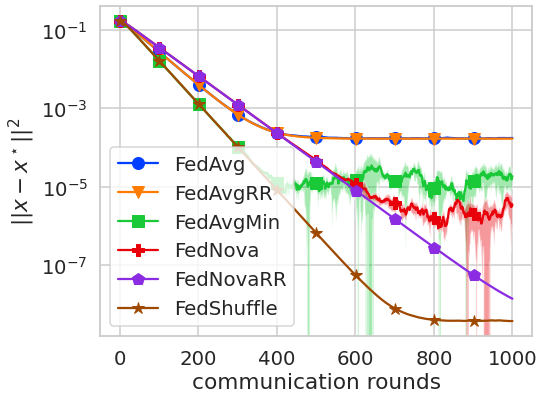

In [13]:
fig, ax = plt.subplots()

for i in range(6):
    x = np.arange(1, comm_rounds + 1)
    quant = [run_stat_s[j][i] for j in range(len(random_seed_s))]
    mean = np.nanmean(quant, axis=0)
    std = np.nanstd(quant, axis=0)
    ax.plot(x, mean, marker=MARKERS[i], markersize=12, markevery=len(x) // 10)
    ax.fill_between(x, mean + std, mean - std, alpha=0.4)
ax.legend(['FedAvg', 'FedAvgRR', 'FedAvgMin', 'FedNova', 'FedNovaRR', 'FedShuffle'])
ax.set_yscale('log')
ax.set_xlabel('communication rounds')
ax.set_ylabel(r"$||x - x^\star||^2$")
plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/toy_all_mom.pdf")
plt.show()

## Partial Participation: FedShuffle 

In [13]:
eta = 1/160 

In [14]:
x_opt = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
tilde_x = np.array([7/36, 8/45, 8/45, 3/20, 3/20, 3/20])
np.sum((x_opt - tilde_x)**2)

0.0018518518518518528

In [15]:
sampled_clients = 2
prob_s = np.ones(n_clients) * (sampled_clients / n_clients)
random_seed_s = [123, 124, 125]
run_stat_s = [np.zeros((2, comm_rounds)) for _ in random_seed_s]


for i, random_seed in enumerate(random_seed_s):
    fedshuffle = QuadObjAlg(n, n_s, 'FedShuffle', eta, False)
    fedshuffle_so = QuadObjAlg(n, n_s, 'FedShuffle', eta, False, True)
    np.random.seed(random_seed)

    for c in range(comm_rounds):
        round_ids = np.random.choice(n_clients, sampled_clients, replace=False)
        run_stat_s[i][0, c] = fedshuffle.local_round(round_ids, prob_s)
        run_stat_s[i][1, c] = fedshuffle_so.local_round(round_ids, prob_s)

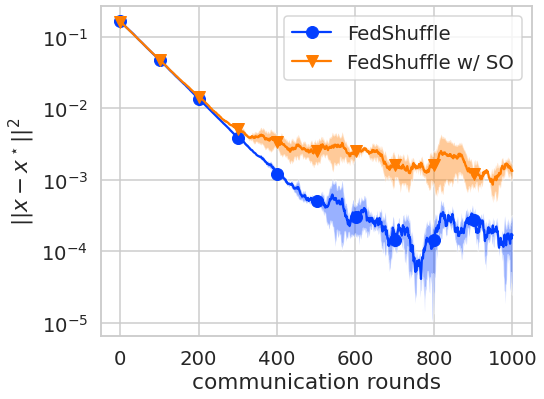

In [16]:
fig, ax = plt.subplots()

for i in range(2):
    x = np.arange(1, comm_rounds + 1)
    quant = [run_stat_s[j][i] for j in range(len(random_seed_s))]
    mean = np.nanmean(quant, axis=0)
    std = np.nanstd(quant, axis=0)
    ax.plot(x, mean, marker=MARKERS[i], markersize=12, markevery=len(x) // 10)
    ax.fill_between(x, mean + std, mean - std, alpha=0.4)
ax.legend(['FedShuffle', 'FedShuffle w/ SO'])
ax.set_yscale('log')
# ax.set_ylim([10**(-3), 0.2])
ax.set_xlabel('communication rounds')
ax.set_ylabel(r"$||x - x^\star||^2$")
plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/toy_sum_one.pdf")
plt.show()

In [6]:
n = 10
n_s = np.array([8, 1, 1])
n_clients = len(n_s)

comm_rounds = 1000

In [27]:
eta = 1/500
eta_is = 1/300

In [28]:
sampled_clients = 1
prob_s = np.ones(n_clients) * (sampled_clients / n_clients)
is_prob_s = n_s / n
random_seed_s = [123, 124, 125]
run_stat_s = [np.zeros((2, comm_rounds)) for _ in random_seed_s]


for i, random_seed in enumerate(random_seed_s):
    fedshuffle = QuadObjAlg(n, n_s, 'FedShuffle', eta)
    fedshuffle_is = QuadObjAlg(n, n_s, 'FedShuffle', eta_is)
    np.random.seed(random_seed)

    for c in range(comm_rounds):
        round_ids = np.random.choice(n_clients, sampled_clients)
        is_round_ids = np.random.choice(n_clients, sampled_clients, p=is_prob_s)
        run_stat_s[i][0, c] = fedshuffle.local_round(round_ids, prob_s)
        run_stat_s[i][1, c] = fedshuffle_is.local_round(is_round_ids, is_prob_s)

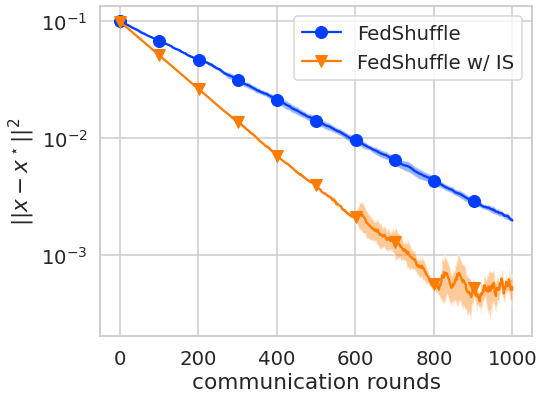

In [30]:
fig, ax = plt.subplots()

for i in range(2):
    x = np.arange(1, comm_rounds + 1)
    quant = [run_stat_s[j][i] for j in range(len(random_seed_s))]
    mean = np.nanmean(quant, axis=0)
    std = np.nanstd(quant, axis=0)
    ax.plot(x, mean, marker=MARKERS[i], markersize=12, markevery=len(x) // 10)
    ax.fill_between(x, mean + std, mean - std, alpha=0.4)
ax.legend(['FedShuffle', 'FedShuffle w/ IS'])
ax.set_yscale('log')
ax.set_xlabel('communication rounds')
ax.set_ylabel(r"$||x - x^\star||^2$")
# ax.set_ylim([10**(-4), 0.2])
plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/toy_is.pdf")
plt.show()